In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from itertools import combinations
from mip import Model, OptimizationStatus, maximize, xsum, BINARY
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Use Case #1: Tests of varying difficulty

Assembling test #1
optimal solution: True
[ 40  48  64  83  90 124 130 191 220 245 257 299 304 311 316 328]

Assembling test #2
optimal solution: True
[ 78  95 123 129 150 179 185 228 263 286 305 336 347 353 358 372]



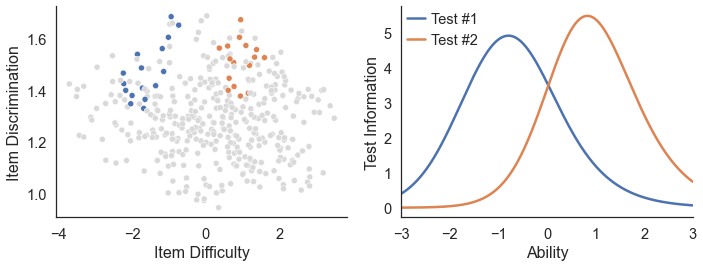

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define test length.
n_item = 16

## Define ability pts.
pts = [
    (-1.5, -1.0, -0.5),                       # Low ability
    (0.5, 1.0, 1.5)                           # High ability
]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1, 2, figsize=(10,4))
palette = ['0.85', '#4c72b0', '#dd8452']

## Load item parameters.
stats = read_csv('stats.csv', index_col=0)
beta  = stats.beta.values                     # Item difficulty
alpha = stats.alpha.values                    # Item discrimination
gamma = stats.gamma.values                    # Guessing
n_clone = len(stats)

## Main loop.
stats['form'] = 0
for d, theta in enumerate(pts):
    
    print(f'Assembling test #{d+1}')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Compute item information.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Define convenience functions.
    def inv_logit(arr):
        return 1. / (1 + np.exp(-arr))
    
    ## Compute p(correct).
    mu = np.outer(alpha, theta) - beta[:,np.newaxis]
    p = gamma[:,np.newaxis] + (1-gamma[:,np.newaxis]) * inv_logit(mu)

    ## Compute information.
    W = np.square(alpha[:,np.newaxis]) * ((1-p) / p) *\
        np.square((p - gamma[:,np.newaxis]) / (1 - gamma[:,np.newaxis]))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Perform test assembly.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize model.
    model = Model("assembly")

    ## Initialize binary variables (one per item clone).
    x = [model.add_var(var_type=BINARY) for i in range(n_clone)]
    
    ## Define model objective (maximize test information).
    model.objective = maximize(xsum(x[i] * W[i].sum() for i in range(n_clone)))
    
    ## Constraint #1: maximum number of item clones.
    ## Specification: sum of binary item weights must equal user-specified 
    ##                total number of item clones.
    model += xsum(x[i] for i in range(n_clone)) == n_item
    
    ## Constraint #2: one clone per item template.
    ## Specification: sum of binary item weights, per item family (6 clones),
    ##                must be equal to or less than one.
    for i in range(0, n_clone, 6): 
        model += xsum(x[i:i+6]) <= 1
        
    ## Perform optimization.
    status = model.optimize(max_seconds=300)
    print('optimal solution: %s' %(status == OptimizationStatus.OPTIMAL))

    ## Extract selected item clones.
    ix = np.array([i for i in range(n_clone) if x[i].x])
    item_ids = ix + 1
    print(item_ids, end='\n\n')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Update test form assignent.
    stats['form'] = np.where(np.in1d(stats.index, item_ids), d+1, stats.form)
        
    ## Compute TIF of test form.
    theta = np.linspace(-3,3,1001)
    mu = np.outer(alpha[ix], theta) - beta[ix,np.newaxis]
    p = gamma[ix,np.newaxis] + (1-gamma[ix,np.newaxis]) * inv_logit(mu)
    w = np.square(alpha[ix,np.newaxis]) * ((1-p) / p) *\
        np.square((p - gamma[ix,np.newaxis]) / (1 - gamma[ix,np.newaxis]))
    
    ## Plot TIF.
    axes[1].plot(theta, w.sum(axis=0), lw=2.5, label=f'Test #{d+1}')
        
## Plot item selection.
sns.scatterplot(x='beta', y='alpha', hue='form', data=stats, palette=palette, ax=axes[0])
        
## Add detail.
axes[0].set(xlabel='Item Difficulty', ylabel='Item Discrimination')
axes[1].set(xlim=(-3,3), xlabel='Ability', ylabel='Test Information')
axes[1].legend(loc=2, handlelength=1.2, handletextpad=0.4, borderaxespad=0, frameon=False)
axes[0].legend_.set_visible(False)

sns.despine()
plt.tight_layout()

## Use Case #2: Parallel short forms

Assembling parallel forms.
optimal solution: True
[[ 41  52 125 132 180 192 246 258 288 292 305 334 340 346 359 378]
 [ 54  76  94 126 131 149 178 191 238 245 253 286 300 304 335 354]
 [ 42  53  78  96 124 130 148 190 227 244 254 294 306 330 348 358]]



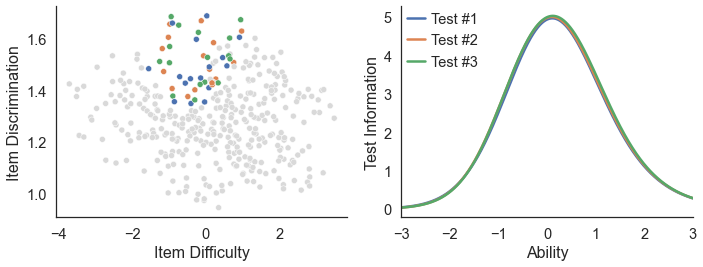

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of forms.
n_form = 3

## Define test length.
n_item = 16

## Define ability pts.
pts = [-1.0, -0.5, 0.0, 0.5, 1.0]

## Define TIF tolerance.
dtol = 1e-2

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load item parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load item parameters.
stats = read_csv('stats.csv', index_col=0)
beta  = stats.beta.values                     # Item difficulty
alpha = stats.alpha.values                    # Item discrimination
gamma = stats.gamma.values                    # Guessing
n_clone = len(stats)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute item information.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define convenience functions.
def inv_logit(arr):
    return 1. / (1 + np.exp(-arr))

## Define ability.
theta = np.copy(pts)

## Compute p(correct).
mu = np.outer(alpha, theta) - beta[:,np.newaxis]
p = gamma[:,np.newaxis] + (1-gamma[:,np.newaxis]) * inv_logit(mu)

## Compute information.
W = np.square(alpha[:,np.newaxis]) * ((1-p) / p) *\
    np.square((p - gamma[:,np.newaxis]) / (1 - gamma[:,np.newaxis]))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform test assembly.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
print('Assembling parallel forms.')

## Initialize model.
model = Model("assembly")

## Initialize binary variables (one per item clone & form).
x = [model.add_var(var_type=BINARY) for i in range(n_form * n_clone)]

## Define model objective (maximize test information).
model.objective = maximize(xsum(x[i] * W[i % n_clone].sum() for i in range(n_form * n_clone)))

## Constraint #1: maximum number of item clones per form.
## Specification: sum of binary item weights must equal user-specified 
##                total number of item clones.
for d in range(n_form):
    model += xsum(x[i] for i in range(d*n_clone,(d+1)*n_clone)) == n_item

## Constraint #2: clones belong to only one form.
## Specification: sum of binary item weights, across each set of weights
##                belonging to a clone, must be equal to or less than one.
for k in range(n_clone):
    model += xsum(x[j] for j in range(k, n_clone * n_form, n_clone)) <= 1
    
## Constraint #3: one clone per item template per form.
## Specification: sum of binary item weights, per item family (6 clones),
##                must be equal to or less than one.
for d in range(n_form):
    for k in range(d*n_clone, (d+1)*n_clone, 6): 
        model += xsum(x[k:k+6]) <= 1
    
## Constraint #4: minimize difference of TIF across forms.
## Specification: minimize difference of TIF, per ability level, across
##                each unique pair of test forms.
for k in range(len(pts)):
    for d1, d2 in combinations(list(range(n_form)), 2):
        model += xsum(x[i] * W[i % n_clone,k] for i in range(d1*n_clone, (d1+1)*n_clone)) -\
                 xsum(x[i] * W[i % n_clone,k] for i in range(d2*n_clone, (d2+1)*n_clone)) <= dtol
    
## Perform optimization.
status = model.optimize(max_seconds=300)
print('optimal solution: %s' %(status == OptimizationStatus.OPTIMAL))

## Extract selected item clones.
ix = np.array([i % n_clone for i in range(n_form * n_clone) if x[i].x]).reshape(n_form,n_item)
item_ids = ix + 1
print(item_ids, end='\n\n')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1, 2, figsize=(10,4))
palette = np.append('0.85', sns.color_palette(n_colors=n_form).as_hex()).tolist()

## Main loop.
stats['form'] = 0
for d, i in enumerate(ix):
    
    ## Update test form assignent.
    stats['form'] = np.where(np.in1d(stats.index, item_ids[d]), d+1, stats.form)
    
    ## Compute TIF of test form.
    theta = np.linspace(-3,3,1001)
    mu = np.outer(alpha[i], theta) - beta[i,np.newaxis]
    p = gamma[i,np.newaxis] + (1-gamma[i,np.newaxis]) * inv_logit(mu)
    w = np.square(alpha[i,np.newaxis]) * ((1-p) / p) *\
        np.square((p - gamma[i,np.newaxis]) / (1 - gamma[i,np.newaxis]))

    ## Plot TIF.
    axes[1].plot(theta, w.sum(axis=0), lw=2.5, label=f'Test #{d+1}')
    
## Plot item selection.
sns.scatterplot(x='beta', y='alpha', hue='form', data=stats, palette=palette, ax=axes[0])
        
## Add detail.
axes[0].set(xlabel='Item Difficulty', ylabel='Item Discrimination')
axes[1].set(xlim=(-3,3), xlabel='Ability', ylabel='Test Information')
axes[1].legend(loc=2, handlelength=1.2, handletextpad=0.4, borderaxespad=0, frameon=False)
axes[0].legend_.set_visible(False)

sns.despine()
plt.tight_layout()